# Comparison of risk estimation methods for a simple case

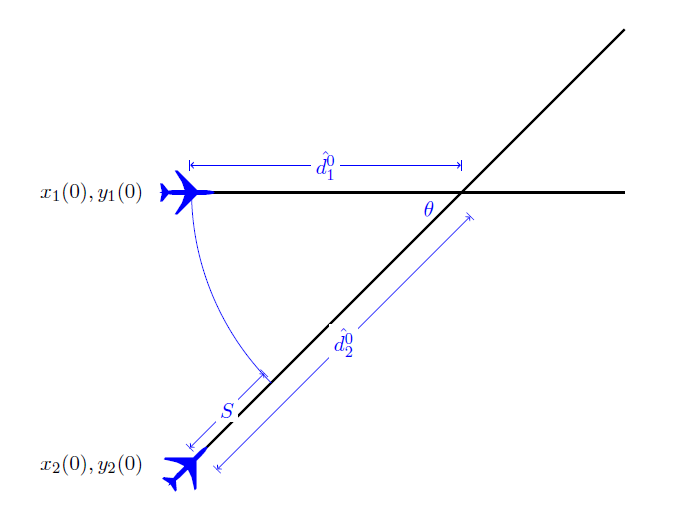

In [1]:
cd ..

/cluster/home/figu/crm4dummies


In [2]:
# %load_ext nb_black
import numpy as np
import crm.probas_overlap as polap


In [3]:
x1, y1 = 0, 0  # NM
x2, y2 = 5, -5  # NM
v1 = 300  # knts
v2 = 300  # knts
theta = 90  # deg

In [4]:
from dataclasses import dataclass


class Conflict:
    def __init__(self, x1, y1, x2, y2, v1, v2, theta):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.v1 = v1
        self.v2 = v2
        self.theta = theta

    def pos_t_sec_ahead(self, t):
        x_1_t = self.x1 + t * self.v1_x / 3600
        y_1_t = self.y1 + t * self.v1_y / 3600
        x_2_t = self.x2 + t * self.v2_x / 3600
        y_2_t = self.y2 + t * self.v2_y / 3600
        return x_1_t, y_1_t, x_2_t, y_2_t

    def horiz_spacing_at_t(self, t):
        x_1_t, y_1_t, x_2_t, y_2_t = self.pos_t_sec_ahead(t)
        return np.sqrt((x_2_t - x_1_t) ** 2 + (y_2_t - y_1_t) ** 2)

    def get_cpa_info(self):
        self.v1_x = self.v1
        self.v1_y = 0
        self.v2_x = self.v2 * np.cos(np.deg2rad(self.theta))
        self.v2_y = self.v2 * np.sin(np.deg2rad(self.theta))
        self.rel_x = self.x2 - self.x1
        self.rel_y = self.y2 - self.y1
        self.rel_vx = self.v2_x - self.v1_x
        self.rel_vy = self.v2_y - self.v1_y
        self.p_dot_p = self.rel_x ** 2 + self.rel_y ** 2
        self.p_dot_v = self.rel_x * self.rel_vx / 3600 + self.rel_y * self.rel_vy / 3600
        self.v_dot_v = (
            self.rel_vx / 3600 * self.rel_vx / 3600
            + self.rel_vy / 3600 * self.rel_vy / 3600
        )
        self.is_converging = self.p_dot_v < 0
        self.horizontal_spacing = np.sqrt(self.p_dot_p)
        self.time_to_cpa = -self.p_dot_v / self.v_dot_v
        (
            self.x_1_at_cpa,
            self.y_1_at_cpa,
            self.x_2_at_cpa,
            self.y_2_at_cpa,
        ) = self.pos_t_sec_ahead(self.time_to_cpa)
        self.rel_x_at_cpa = self.x_2_at_cpa - self.x_1_at_cpa
        self.rel_y_at_cpa = self.y_2_at_cpa - self.y_1_at_cpa
        self.horizontal_spacing_at_cpa = np.sqrt(
            self.rel_x_at_cpa ** 2 + self.rel_y_at_cpa ** 2
        )
        return self

In [5]:
simple_conflict = Conflict(x1, y1, x2, y2, v1, v2, theta).get_cpa_info()
simple_conflict.__dict__

{'x1': 0,
 'y1': 0,
 'x2': 5,
 'y2': -5,
 'v1': 300,
 'v2': 300,
 'theta': 90,
 'v1_x': 300,
 'v1_y': 0,
 'v2_x': 1.8369701987210297e-14,
 'v2_y': 300.0,
 'rel_x': 5,
 'rel_y': -5,
 'rel_vx': -300.0,
 'rel_vy': 300.0,
 'p_dot_p': 50,
 'p_dot_v': -0.8333333333333334,
 'v_dot_v': 0.013888888888888888,
 'is_converging': True,
 'horizontal_spacing': 7.0710678118654755,
 'time_to_cpa': 60.00000000000001,
 'x_1_at_cpa': 5.000000000000001,
 'y_1_at_cpa': 0.0,
 'x_2_at_cpa': 5.0,
 'y_2_at_cpa': 8.881784197001252e-16,
 'rel_x_at_cpa': -8.881784197001252e-16,
 'rel_y_at_cpa': 8.881784197001252e-16,
 'horizontal_spacing_at_cpa': 1.2560739669470201e-15}

## Assuming straight track and risk at CPA only

In [6]:
NSE_1 = NSE_2 = 20 / 1852  # Nautical Miles
ap_length = 0.038
polap.proba_h_olap_norm_norm_nse_circle(
    simple_conflict.horizontal_spacing_at_cpa, NSE_1, NSE_2, ap_length / 2
)

0.9488456128993599

## Summing all the risk along the path

In [7]:
import scipy.integrate as integrate

tf = simple_conflict.time_to_cpa * 2
integrate.quad(
    lambda t: polap.proba_h_olap_norm_norm_nse_circle(
        simple_conflict.horiz_spacing_at_t(t), NSE_1, NSE_2, ap_length / 2
    ),
    0,
    tf,
    points=simple_conflict.time_to_cpa,
)[0]

0.28993615181584703

In [8]:
delta=0.001
integrate.quad(
    lambda t: polap.proba_h_olap_norm_norm_nse_circle(
        simple_conflict.horiz_spacing_at_t(t), NSE_1, NSE_2, ap_length / 2
    ),
    simple_conflict.time_to_cpa - delta,
    simple_conflict.time_to_cpa + delta,
    points=simple_conflict.time_to_cpa,
)[0]

0.00189767962943052